# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import pandas as pd
import numpy as np

import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import re

from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

import pickle

from sqlalchemy import create_engine

%matplotlib inline
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql_table('df', con=engine)

# Names all columns starting at the fifth column as "categories"
categories = df.columns[4:]

# X contains values from message column and y contains values from categories columns
X = df[['message']].values[:, 0]
y = df[categories].values

### 2. Write a tokenization function to process your text data

In [3]:
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'


def tokenize(text, lemmatizer=WordNetLemmatizer()):
    # Detects URLs
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, 'urlplaceholder')
    
    # Normalizes and tokenizes (removes punctuations and converts to lowercase)
    tokens = nltk.word_tokenize(re.sub(r"[^a-zA-Z0-9]", " ", text.lower()))
    
    # Removes stopwords
    tokens = [t for t in tokens if t not in stopwords.words('english')]

    # Reduces words to root form
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    
    return tokens

In [4]:
# Converts text in X to word count vectors
vect = CountVectorizer(tokenizer=tokenize)
X_vectorized = vect.fit_transform(X)

In [5]:
# Converts vocabulary into a Pandas dataframe
keys, values = [], []
for k, v in vect.vocabulary_.items():
    keys.append(k)
    values.append(v)

vocabulary = pd.DataFrame.from_dict({'words': keys, 'counts': values})

In [6]:
# Displays the count of each occurence of the words in X
print(vocabulary)

             words  counts
0          weather   30238
1           update   29379
2             cold    6340
3            front   11387
4             cuba    7416
5            could    7131
6              pas   20753
7            haiti   12561
8        hurricane   13480
9          looking   16810
10         someone   26030
11            name   18944
12              un   28973
13          report   23504
14         leogane   16388
15              80    1209
16              90    1318
17       destroyed    8201
18        hospital   13291
19              st   26378
20           croix    7342
21     functioning   11476
22            need   19122
23          supply   27017
24     desperately    8168
25             say   24686
26            west   30321
27            side   25545
28            rest   23660
29         country    7157
...            ...     ...
31115     farchana   10518
31116       abeche    1472
31117          goz   12111
31118        beida    3950
31119   expediency   10273
3

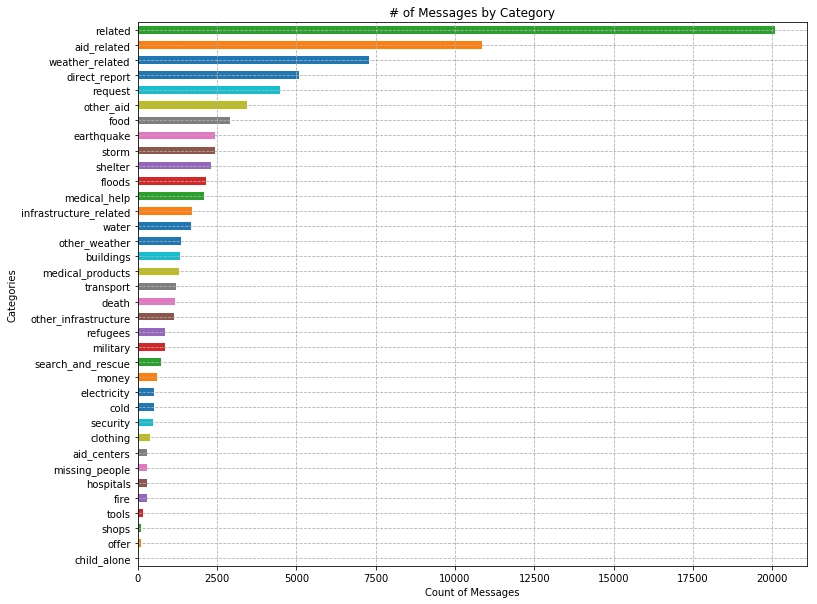

In [7]:
plt.figure(figsize=(30, 10))
plt.subplots_adjust(wspace=0.5)


ax = plt.subplot(1, 2, 2)
df[categories].sum().sort_values().plot.barh(ax=ax)
plt.title('# of Messages by Category')
plt.ylabel('Categories')
plt.xlabel('Count of Messages')
plt.grid(linestyle='dashed')
plt.rcParams["font.size"] = "11"

plt.show()

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [8]:
# Builds a pipeline that counts individual words, normalizes those counts, and predicts multiple target variables
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier(class_weight='balanced')))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [9]:
# Divides dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [10]:
# Fits pipeline on the training set
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...oob_score=False, random_state=None,
            verbose=0, warm_start=False),
           n_jobs=1))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [11]:
# Creates a function that displays results from predictions
def multioutput_classification_report(y_true, y_pred):
    for i in range(0, len(categories)):
        print(categories[i] + ":")
        print("\tAccuracy: {:.4f}\tPrecision: {:.4f}\tRecall: {:.4f}\tF1_score: {:.4f}".format(
            accuracy_score(y_true[:, i], y_pred[:, i]),
            precision_score(y_true[:, i], y_pred[:, i], average='weighted'),
            recall_score(y_true[:, i], y_pred[:, i], average='weighted'),
            f1_score(y_true[:, i], y_pred[:, i], average='weighted')
        ))

In [12]:
# Predicts messages in the training set based on categories in the training set
y_pred = pipeline.predict(X_train)

multioutput_classification_report(y_train, y_pred)

related:
	Accuracy: 0.9894	Precision: 0.9894	Recall: 0.9894	F1_score: 0.9894
request:
	Accuracy: 0.9876	Precision: 0.9876	Recall: 0.9876	F1_score: 0.9874
offer:
	Accuracy: 0.9985	Precision: 0.9985	Recall: 0.9985	F1_score: 0.9984
aid_related:
	Accuracy: 0.9854	Precision: 0.9855	Recall: 0.9854	F1_score: 0.9854
medical_help:
	Accuracy: 0.9886	Precision: 0.9886	Recall: 0.9886	F1_score: 0.9882
medical_products:
	Accuracy: 0.9913	Precision: 0.9913	Recall: 0.9913	F1_score: 0.9909
search_and_rescue:
	Accuracy: 0.9937	Precision: 0.9937	Recall: 0.9937	F1_score: 0.9933
security:
	Accuracy: 0.9948	Precision: 0.9948	Recall: 0.9948	F1_score: 0.9944
military:
	Accuracy: 0.9951	Precision: 0.9950	Recall: 0.9951	F1_score: 0.9949
child_alone:
	Accuracy: 1.0000	Precision: 1.0000	Recall: 1.0000	F1_score: 1.0000
water:
	Accuracy: 0.9955	Precision: 0.9955	Recall: 0.9955	F1_score: 0.9954
food:
	Accuracy: 0.9927	Precision: 0.9928	Recall: 0.9927	F1_score: 0.9926
shelter:
	Accuracy: 0.9921	Precision: 0.9922	Reca

In [13]:
# Predicts messages in the test set based on categories in the test set
y_pred = pipeline.predict(X_test)

multioutput_classification_report(y_test, y_pred)

related:
	Accuracy: 0.8146	Precision: 0.8036	Recall: 0.8146	F1_score: 0.8066
request:
	Accuracy: 0.8892	Precision: 0.8809	Recall: 0.8892	F1_score: 0.8783
offer:
	Accuracy: 0.9966	Precision: 0.9933	Recall: 0.9966	F1_score: 0.9950
aid_related:
	Accuracy: 0.7486	Precision: 0.7466	Recall: 0.7486	F1_score: 0.7449
medical_help:
	Accuracy: 0.9248	Precision: 0.9028	Recall: 0.9248	F1_score: 0.9019
medical_products:
	Accuracy: 0.9500	Precision: 0.9389	Recall: 0.9500	F1_score: 0.9290
search_and_rescue:
	Accuracy: 0.9727	Precision: 0.9734	Recall: 0.9727	F1_score: 0.9597
security:
	Accuracy: 0.9823	Precision: 0.9652	Recall: 0.9823	F1_score: 0.9737
military:
	Accuracy: 0.9658	Precision: 0.9572	Recall: 0.9658	F1_score: 0.9517
child_alone:
	Accuracy: 1.0000	Precision: 1.0000	Recall: 1.0000	F1_score: 1.0000
water:
	Accuracy: 0.9535	Precision: 0.9510	Recall: 0.9535	F1_score: 0.9437
food:
	Accuracy: 0.9185	Precision: 0.9142	Recall: 0.9185	F1_score: 0.9017
shelter:
	Accuracy: 0.9306	Precision: 0.9206	Reca

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 6. Improve your model
Use grid search to find better parameters. 

In [14]:
parameters = {
    'clf__estimator__n_estimators': [50, 100]
}

cv = GridSearchCV(estimator=pipeline, param_grid=parameters, cv=3, scoring='f1_weighted', verbose=3)

In [15]:
cv.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] clf__estimator__n_estimators=50 .................................


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__n_estimators=50, score=0.5474089416541853, total= 4.4min
[CV] clf__estimator__n_estimators=50 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.5min remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__n_estimators=50, score=0.5387660453117729, total= 4.5min
[CV] clf__estimator__n_estimators=50 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.2min remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__n_estimators=50, score=0.5505913036925019, total= 4.5min
[CV] clf__estimator__n_estimators=100 ................................


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__n_estimators=100, score=0.549298528451953, total= 7.4min
[CV] clf__estimator__n_estimators=100 ................................


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__n_estimators=100, score=0.5490508923201218, total= 7.6min
[CV] clf__estimator__n_estimators=100 ................................


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__n_estimators=100, score=0.5524727257183204, total= 7.7min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 43.8min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...oob_score=False, random_state=None,
            verbose=0, warm_start=False),
           n_jobs=1))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__estimator__n_estimators': [50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=3)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [16]:
y_pred = cv.predict(X_train)

multioutput_classification_report(y_train, y_pred)

related:
	Accuracy: 0.9979	Precision: 0.9979	Recall: 0.9979	F1_score: 0.9979
request:
	Accuracy: 0.9989	Precision: 0.9989	Recall: 0.9989	F1_score: 0.9989
offer:
	Accuracy: 0.9998	Precision: 0.9998	Recall: 0.9998	F1_score: 0.9998
aid_related:
	Accuracy: 0.9988	Precision: 0.9988	Recall: 0.9988	F1_score: 0.9988
medical_help:
	Accuracy: 0.9993	Precision: 0.9993	Recall: 0.9993	F1_score: 0.9993
medical_products:
	Accuracy: 0.9996	Precision: 0.9996	Recall: 0.9996	F1_score: 0.9996
search_and_rescue:
	Accuracy: 0.9996	Precision: 0.9996	Recall: 0.9996	F1_score: 0.9996
security:
	Accuracy: 0.9996	Precision: 0.9996	Recall: 0.9996	F1_score: 0.9996
military:
	Accuracy: 0.9996	Precision: 0.9996	Recall: 0.9996	F1_score: 0.9996
child_alone:
	Accuracy: 1.0000	Precision: 1.0000	Recall: 1.0000	F1_score: 1.0000
water:
	Accuracy: 0.9999	Precision: 0.9999	Recall: 0.9999	F1_score: 0.9999
food:
	Accuracy: 0.9999	Precision: 0.9999	Recall: 0.9999	F1_score: 0.9999
shelter:
	Accuracy: 0.9998	Precision: 0.9998	Reca

In [17]:
y_pred = cv.predict(X_test)

multioutput_classification_report(y_test, y_pred)

related:
	Accuracy: 0.8300	Precision: 0.8185	Recall: 0.8300	F1_score: 0.8163
request:
	Accuracy: 0.9005	Precision: 0.8947	Recall: 0.9005	F1_score: 0.8916
offer:
	Accuracy: 0.9966	Precision: 0.9933	Recall: 0.9966	F1_score: 0.9950
aid_related:
	Accuracy: 0.7782	Precision: 0.7772	Recall: 0.7782	F1_score: 0.7775
medical_help:
	Accuracy: 0.9254	Precision: 0.9108	Recall: 0.9254	F1_score: 0.8953
medical_products:
	Accuracy: 0.9501	Precision: 0.9389	Recall: 0.9501	F1_score: 0.9296
search_and_rescue:
	Accuracy: 0.9725	Precision: 0.9733	Recall: 0.9725	F1_score: 0.9593
security:
	Accuracy: 0.9823	Precision: 0.9652	Recall: 0.9823	F1_score: 0.9737
military:
	Accuracy: 0.9651	Precision: 0.9549	Recall: 0.9651	F1_score: 0.9492
child_alone:
	Accuracy: 1.0000	Precision: 1.0000	Recall: 1.0000	F1_score: 1.0000
water:
	Accuracy: 0.9513	Precision: 0.9492	Recall: 0.9513	F1_score: 0.9398
food:
	Accuracy: 0.9396	Precision: 0.9355	Recall: 0.9396	F1_score: 0.9348
shelter:
	Accuracy: 0.9356	Precision: 0.9292	Reca

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [18]:
# Builds a pipeline using the AdaBoost classifier
pipeline_ada = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(
        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'))
    ))
])

parameters_ada = {
    'clf__estimator__learning_rate': [0.1, 0.3],
    'clf__estimator__n_estimators': [200, 400]
}

cv_ada = GridSearchCV(estimator=pipeline_ada, param_grid=parameters_ada, cv=3, scoring='f1_weighted', verbose=3)

In [19]:
# Produces a function that represents a line that best fits all the categories.
# This line function can be used to estimate (predict) other results
cv_ada.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200, score=0.6223461454255799, total= 6.1min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.3min remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200, score=0.6205066152116923, total= 6.0min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 14.6min remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200, score=0.6232495121049335, total= 6.1min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=400 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=400, score=0.6317949606532548, total=10.7min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=400 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=400, score=0.6305171087972324, total=10.9min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=400 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=400, score=0.6300874403358379, total=10.8min
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=200 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=200, score=0.6322307072123016, total= 6.1min
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=200 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=200, score=0.6339702325345058, total= 6.1min
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=200 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=200, score=0.6332024900282064, total= 6.1min
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=400 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=400, score=0.6386737769945916, total=10.8min
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=400 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=400, score=0.6379063008067651, total=10.8min
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=400 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=400, score=0.6378455002194457, total=10.8min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 118.2min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...er='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
           n_jobs=1))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__estimator__learning_rate': [0.1, 0.3], 'clf__estimator__n_estimators': [200, 400]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=3)

In [20]:
# Displays parameters with the best results for the Adaboost model
cv_ada.best_params_

{'clf__estimator__learning_rate': 0.3, 'clf__estimator__n_estimators': 400}

In [21]:
y_pred = cv_ada.predict(X_train)

multioutput_classification_report(y_train, y_pred)

related:
	Accuracy: 0.7710	Precision: 0.8524	Recall: 0.7710	F1_score: 0.7877
request:
	Accuracy: 0.8783	Precision: 0.8979	Recall: 0.8783	F1_score: 0.8847
offer:
	Accuracy: 0.9862	Precision: 0.9964	Recall: 0.9862	F1_score: 0.9902
aid_related:
	Accuracy: 0.7989	Precision: 0.7982	Recall: 0.7989	F1_score: 0.7984
medical_help:
	Accuracy: 0.8990	Precision: 0.9370	Recall: 0.8990	F1_score: 0.9122
medical_products:
	Accuracy: 0.9139	Precision: 0.9599	Recall: 0.9139	F1_score: 0.9303
search_and_rescue:
	Accuracy: 0.9092	Precision: 0.9767	Recall: 0.9092	F1_score: 0.9349
security:
	Accuracy: 0.9317	Precision: 0.9850	Recall: 0.9317	F1_score: 0.9527
military:
	Accuracy: 0.9677	Precision: 0.9824	Recall: 0.9677	F1_score: 0.9725
child_alone:
	Accuracy: 1.0000	Precision: 1.0000	Recall: 1.0000	F1_score: 1.0000
water:
	Accuracy: 0.9541	Precision: 0.9689	Recall: 0.9541	F1_score: 0.9588
food:
	Accuracy: 0.9554	Precision: 0.9602	Recall: 0.9554	F1_score: 0.9570
shelter:
	Accuracy: 0.9430	Precision: 0.9552	Reca

In [22]:
y_pred = cv_ada.predict(X_test)

multioutput_classification_report(y_test, y_pred)

related:
	Accuracy: 0.7513	Precision: 0.8307	Recall: 0.7513	F1_score: 0.7690
request:
	Accuracy: 0.8578	Precision: 0.8807	Recall: 0.8578	F1_score: 0.8658
offer:
	Accuracy: 0.9776	Precision: 0.9938	Recall: 0.9776	F1_score: 0.9855
aid_related:
	Accuracy: 0.7817	Precision: 0.7809	Recall: 0.7817	F1_score: 0.7812
medical_help:
	Accuracy: 0.8706	Precision: 0.9149	Recall: 0.8706	F1_score: 0.8880
medical_products:
	Accuracy: 0.8874	Precision: 0.9387	Recall: 0.8874	F1_score: 0.9081
search_and_rescue:
	Accuracy: 0.8865	Precision: 0.9587	Recall: 0.8865	F1_score: 0.9180
security:
	Accuracy: 0.9002	Precision: 0.9710	Recall: 0.9002	F1_score: 0.9324
military:
	Accuracy: 0.9530	Precision: 0.9669	Recall: 0.9530	F1_score: 0.9586
child_alone:
	Accuracy: 1.0000	Precision: 1.0000	Recall: 1.0000	F1_score: 1.0000
water:
	Accuracy: 0.9481	Precision: 0.9643	Recall: 0.9481	F1_score: 0.9534
food:
	Accuracy: 0.9481	Precision: 0.9530	Recall: 0.9481	F1_score: 0.9499
shelter:
	Accuracy: 0.9292	Precision: 0.9427	Reca

### 9. Export your model as a pickle file

In [23]:
with open('adaboost_cv.pkl', 'wb') as file:
    pickle.dump(cv_ada, file)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.